In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### dataset information

In [4]:
from datetime import datetime

dataset = "cifar10"
dims = (32, 32, 3)
num_classes = 10
labels_per_class = 'full' # full
batch_size = 128
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring 
    + '_baseline'
)
print(datestring)

cifar10_full____2020_08_09_21_54_03_152503_baseline


### Load packages

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [6]:
from tfumap.load_datasets import load_CIFAR10, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_CIFAR10(flatten=False)
X_train.shape

(40000, 32, 32, 3)

In [7]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build network

In [8]:
from tensorflow.keras import datasets, layers, models
from tensorflow_addons.layers import WeightNormalization

def conv_block(filts, name, kernel_size = (3, 3), padding = "same", **kwargs):
    return WeightNormalization(
        layers.Conv2D(
            filts, kernel_size, activation=None, padding=padding, **kwargs
        ),
        name="conv"+name,
    )
#CNN13
#See: 
#https://github.com/vikasverma1077/ICT/blob/master/networks/lenet.py
#https://github.com/brain-research/realistic-ssl-evaluation

In [9]:

lr_alpha = 0.1
dropout_rate = 0.5
num_classes = 10
input_shape = (32, 32, 3)
model = models.Sequential()
model.add(tf.keras.Input(shape=input_shape))
### conv1a
name = '1a'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1b
name = '1b'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv1c
name = '1c'
model.add(conv_block(name = name, filts = 128, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp1"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop1"))

### conv2a
name = '2a'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha))

### conv2b
name = '2b'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv2c
name = '2c'
model.add(conv_block(name = name, filts = 256, kernel_size = (3,3), padding="same"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', name="mp2"))
# dropout
model.add(layers.Dropout(dropout_rate, name="drop2"))

### conv3a
name = '3a'
model.add(conv_block(name = name, filts = 512, kernel_size = (3,3), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3b
name = '3b'
model.add(conv_block(name = name, filts = 256, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

### conv3c
name = '3c'
model.add(conv_block(name = name, filts = 128, kernel_size = (1,1), padding="valid"))
model.add(layers.BatchNormalization(name="bn"+name))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelu'+name))

# max pooling
model.add(layers.AveragePooling2D(pool_size=(6, 6), strides=2, padding='valid'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation=None, name='z'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc1'))
model.add(WeightNormalization(layers.Dense(256, activation=None)))
model.add(layers.LeakyReLU(alpha=lr_alpha, name = 'lrelufc2'))
model.add(WeightNormalization(layers.Dense(num_classes, activation=None)))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1a (WeightNormalization) (None, 32, 32, 128)       7297      
_________________________________________________________________
bn1a (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1a (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1b (WeightNormalization) (None, 32, 32, 128)       295297    
_________________________________________________________________
bn1b (BatchNormalization)    (None, 32, 32, 128)       512       
_________________________________________________________________
lrelu1b (LeakyReLU)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv1c (WeightNormalization) (None, 32, 32, 128)       2

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=50, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

In [12]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)

In [13]:
model.compile(tf.keras.optimizers.Adam(1e-4), loss = loss, metrics=['accuracy'])

In [14]:
Y_valid_one_hot = tf.keras.backend.one_hot(
    Y_valid, num_classes
)

In [15]:
Y_labeled_one_hot = tf.keras.backend.one_hot(
    Y_labeled, num_classes
)

In [16]:
history = model.fit(
    X_labeled,
    Y_labeled_one_hot,
    batch_size=batch_size,
    epochs=500,
    validation_data=(X_valid, Y_valid_one_hot),
    callbacks = [early_stopping]
)

Epoch 1/500
313/313 [==============================] - 17s 53ms/step - loss: 1.9291 - accuracy: 0.3880 - val_loss: 2.6994 - val_accuracy: 0.2925
Epoch 2/500
313/313 [==============================] - 16s 50ms/step - loss: 1.7077 - accuracy: 0.5225 - val_loss: 2.3860 - val_accuracy: 0.3725
Epoch 3/500
313/313 [==============================] - 16s 50ms/step - loss: 1.6034 - accuracy: 0.5869 - val_loss: 2.2033 - val_accuracy: 0.3997
Epoch 4/500
313/313 [==============================] - 26s 84ms/step - loss: 1.5276 - accuracy: 0.6326 - val_loss: 2.0481 - val_accuracy: 0.4471
Epoch 5/500
313/313 [==============================] - 29s 94ms/step - loss: 1.4699 - accuracy: 0.6683 - val_loss: 1.8367 - val_accuracy: 0.5300
Epoch 6/500
313/313 [==============================] - 31s 100ms/step - loss: 1.4241 - accuracy: 0.6964 - val_loss: 1.5870 - val_accuracy: 0.6285
Epoch 7/500
313/313 [==============================] - 31s 100ms/step - loss: 1.3795 - accuracy: 0.7222 - val_loss: 1.6240 - val_

313/313 [==============================] - 64s 203ms/step - loss: 0.9285 - accuracy: 0.9736 - val_loss: 1.1256 - val_accuracy: 0.8717
Epoch 58/500
313/313 [==============================] - 64s 203ms/step - loss: 0.9279 - accuracy: 0.9733 - val_loss: 1.1313 - val_accuracy: 0.8695
Epoch 59/500
313/313 [==============================] - 64s 203ms/step - loss: 0.9247 - accuracy: 0.9748 - val_loss: 1.1205 - val_accuracy: 0.8720
Epoch 60/500
313/313 [==============================] - 60s 192ms/step - loss: 0.9241 - accuracy: 0.9750 - val_loss: 1.1335 - val_accuracy: 0.8709
Epoch 61/500
313/313 [==============================] - 54s 172ms/step - loss: 0.9212 - accuracy: 0.9768 - val_loss: 1.1478 - val_accuracy: 0.8628
Epoch 62/500
313/313 [==============================] - 54s 172ms/step - loss: 0.9205 - accuracy: 0.9764 - val_loss: 1.1830 - val_accuracy: 0.8496
Epoch 63/500
313/313 [==============================] - 53s 169ms/step - loss: 0.9205 - accuracy: 0.9762 - val_loss: 1.1213 - val_a

Epoch 113/500
313/313 [==============================] - 29s 93ms/step - loss: 0.8915 - accuracy: 0.9887 - val_loss: 1.1173 - val_accuracy: 0.8809
Epoch 114/500
313/313 [==============================] - 29s 94ms/step - loss: 0.8884 - accuracy: 0.9905 - val_loss: 1.1287 - val_accuracy: 0.8764
Epoch 115/500
313/313 [==============================] - 30s 94ms/step - loss: 0.8873 - accuracy: 0.9916 - val_loss: 1.1170 - val_accuracy: 0.8821
Epoch 116/500
313/313 [==============================] - 29s 94ms/step - loss: 0.8889 - accuracy: 0.9906 - val_loss: 1.1022 - val_accuracy: 0.8913
Epoch 117/500
313/313 [==============================] - 30s 95ms/step - loss: 0.8880 - accuracy: 0.9912 - val_loss: 1.1051 - val_accuracy: 0.8866
Epoch 118/500
313/313 [==============================] - 30s 94ms/step - loss: 0.8886 - accuracy: 0.9907 - val_loss: 1.1143 - val_accuracy: 0.8825
Epoch 119/500
313/313 [==============================] - 29s 94ms/step - loss: 0.8895 - accuracy: 0.9899 - val_loss: 1

Epoch 169/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8820 - accuracy: 0.9927 - val_loss: 1.0907 - val_accuracy: 0.8949
Epoch 170/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8791 - accuracy: 0.9949 - val_loss: 1.0915 - val_accuracy: 0.8972
Epoch 171/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8806 - accuracy: 0.9940 - val_loss: 1.1354 - val_accuracy: 0.8786
Epoch 172/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8814 - accuracy: 0.9934 - val_loss: 1.1030 - val_accuracy: 0.8912
Epoch 173/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8792 - accuracy: 0.9946 - val_loss: 1.0997 - val_accuracy: 0.8911
Epoch 174/500
313/313 [==============================] - 16s 50ms/step - loss: 0.8802 - accuracy: 0.9941 - val_loss: 1.1184 - val_accuracy: 0.8841
Epoch 175/500
313/313 [==============================] - 15s 50ms/step - loss: 0.8799 - accuracy: 0.9942 - val_loss: 1

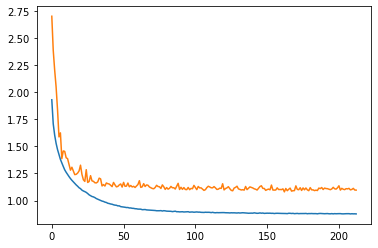

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

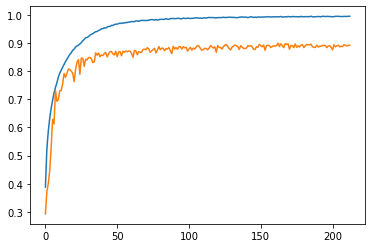

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [19]:
submodel = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
    )
z = submodel.predict(X_train)
np.shape(z)

(40000, 256)

In [20]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:43:53 2020 Finding Nearest Neighbors
Sun Aug  9 23:43:53 2020 Building RP forest with 15 trees
Sun Aug  9 23:43:55 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Sun Aug  9 23:44:04 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:44:07 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Aug  9 23:44:32 2020 Finished embedding


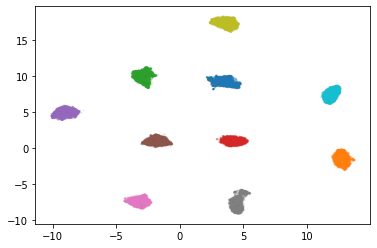

In [21]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Aug  9 23:44:36 2020 Finding Nearest Neighbors
Sun Aug  9 23:44:36 2020 Building RP forest with 10 trees
Sun Aug  9 23:44:36 2020 parallel NN descent for 13 iterations
	 0  /  13
	 1  /  13
	 2  /  13
	 3  /  13
Sun Aug  9 23:44:37 2020 Finished Nearest Neighbor Search
Sun Aug  9 23:44:37 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Aug  9 23:44:54 2020 Finished embedding


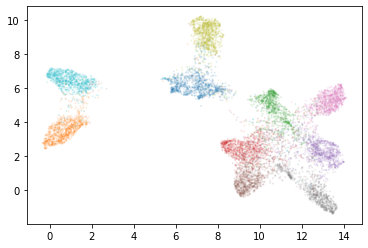

In [22]:
z_valid = submodel.predict(X_valid)
np.shape(z_valid)
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z_valid.reshape(len(z_valid), np.product(np.shape(z_valid)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

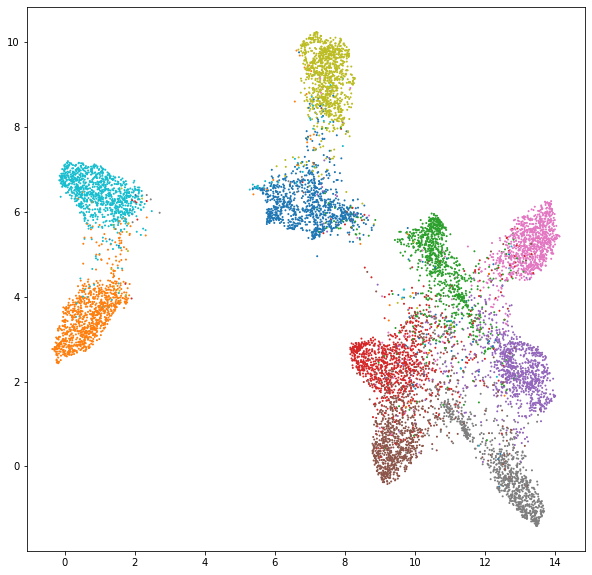

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=Y_valid.flatten(), s= 1, alpha = 1, cmap = plt.cm.tab10)

In [24]:
predictions = model.predict(X_valid)

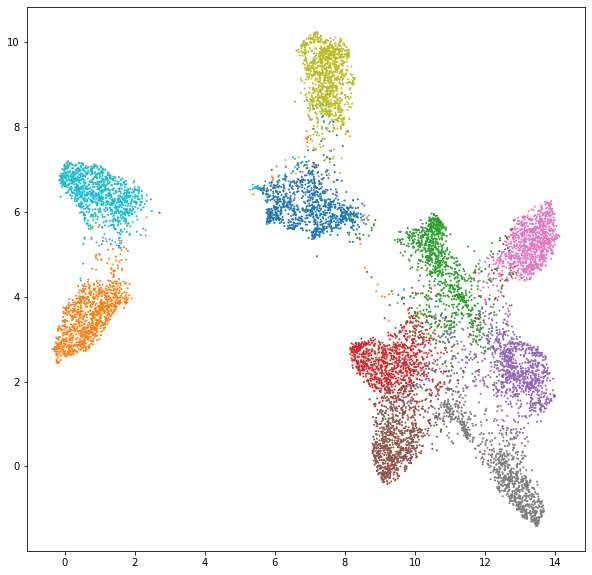

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:, 0], embedding[:, 1], c=np.argmax(predictions, axis=1), s= 1, alpha = 1, cmap = plt.cm.tab10)

### save results

In [26]:
# save score, valid embedding, weights, results

In [27]:
from tfumap.paths import MODEL_DIR, ensure_dir

In [28]:
save_folder = MODEL_DIR / 'semisupervised-keras' / dataset / str(labels_per_class) / datestring
ensure_dir(save_folder)

#### save weights

In [29]:
encoder = tf.keras.models.Model(
        [model.inputs[0]], [model.get_layer('z').output]
)

In [30]:
encoder.save_weights((save_folder / "encoder").as_posix())

In [31]:
classifier = tf.keras.models.Model(
        [tf.keras.Input(tensor=model.get_layer('weight_normalization').input)], [model.outputs[0]]
)
print([i.name for i in classifier.layers])

['input_2', 'weight_normalization', 'lrelufc1', 'weight_normalization_1', 'lrelufc2', 'weight_normalization_2']


In [32]:
classifier.save_weights((save_folder / "classifier").as_posix())

In [41]:
model.save_weights((save_folder / "full_model").as_posix())

#### save score

In [33]:
Y_test_one_hot = tf.keras.backend.one_hot(
    Y_test, num_classes
)
result = model.evaluate(X_test, Y_test_one_hot)

313/313 [==============================] - 3s 9ms/step - loss: 1.0994 - accuracy: 0.8923


In [34]:
np.save(save_folder / 'test_loss.npy', result)

#### save embedding

In [36]:
z = encoder.predict(X_train)

UMAP(dens_frac=0.0, dens_lambda=0.0, verbose=True)
Construct fuzzy simplicial set
Mon Aug 10 09:28:32 2020 Finding Nearest Neighbors
Mon Aug 10 09:28:32 2020 Building RP forest with 15 trees
Mon Aug 10 09:28:32 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
Mon Aug 10 09:28:34 2020 Finished Nearest Neighbor Search
Mon Aug 10 09:28:34 2020 Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Aug 10 09:29:02 2020 Finished embedding


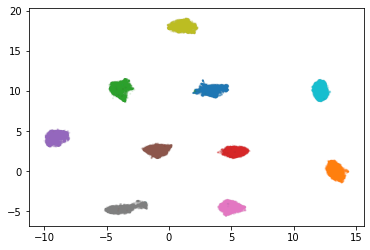

In [37]:
reducer = umap.UMAP(verbose=True)

embedding = reducer.fit_transform(z.reshape(len(z), np.product(np.shape(z)[1:])))

plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_train.flatten(), s= 1, alpha = 0.1, cmap = plt.cm.tab10)

In [38]:
np.save(save_folder / 'train_embedding.npy', embedding)

#### save results

In [39]:
import pickle

In [40]:
with open(save_folder / 'history.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)